## Интеллектуальный анализ данных – весна 2022
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [312]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [313]:
X.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [314]:
(X.dtypes == 'object').values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [315]:
from sklearn.model_selection import train_test_split


По сути ведь np.random.seed() и random_state используются для одного и того же?

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.3, 
                                                    random_state=42)

In [317]:
y_train

array([0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0,
       1, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 2, 0, 1, 1, 0, 1, 1])

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [318]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [319]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
accuracy_train = []
accuracy_test = []
k = [1, 3, 5, 10, 15, 25]
for i in k:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train[['alcohol', 'magnesium']], y_train)
    y_train_predict = knn.predict(X_train[['alcohol', 'magnesium']])
    y_test_predict = knn.predict(X_test[['alcohol', 'magnesium']])
    accuracy_train.append(round(accuracy_score(y_train, y_train_predict), 2))
    accuracy_test.append(accuracy_score(y_test, y_test_predict))
print(pd.DataFrame({'NN': k, 'Train': accuracy_train, 'Test': accuracy_test}))


   NN  Train   Test
0   1   1.00  0.592
1   3   0.89  0.608
2   5   0.81  0.640
3  10   0.77  0.648
4  15   0.64  0.640
5  25   0.66  0.672


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [320]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [321]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

In [322]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools


GridSpec(2, 3)[0:1, 0:1]
GridSpec(2, 3)[0:1, 1:2]
GridSpec(2, 3)[0:1, 2:3]
GridSpec(2, 3)[1:2, 0:1]
GridSpec(2, 3)[1:2, 1:2]
GridSpec(2, 3)[1:2, 2:3]


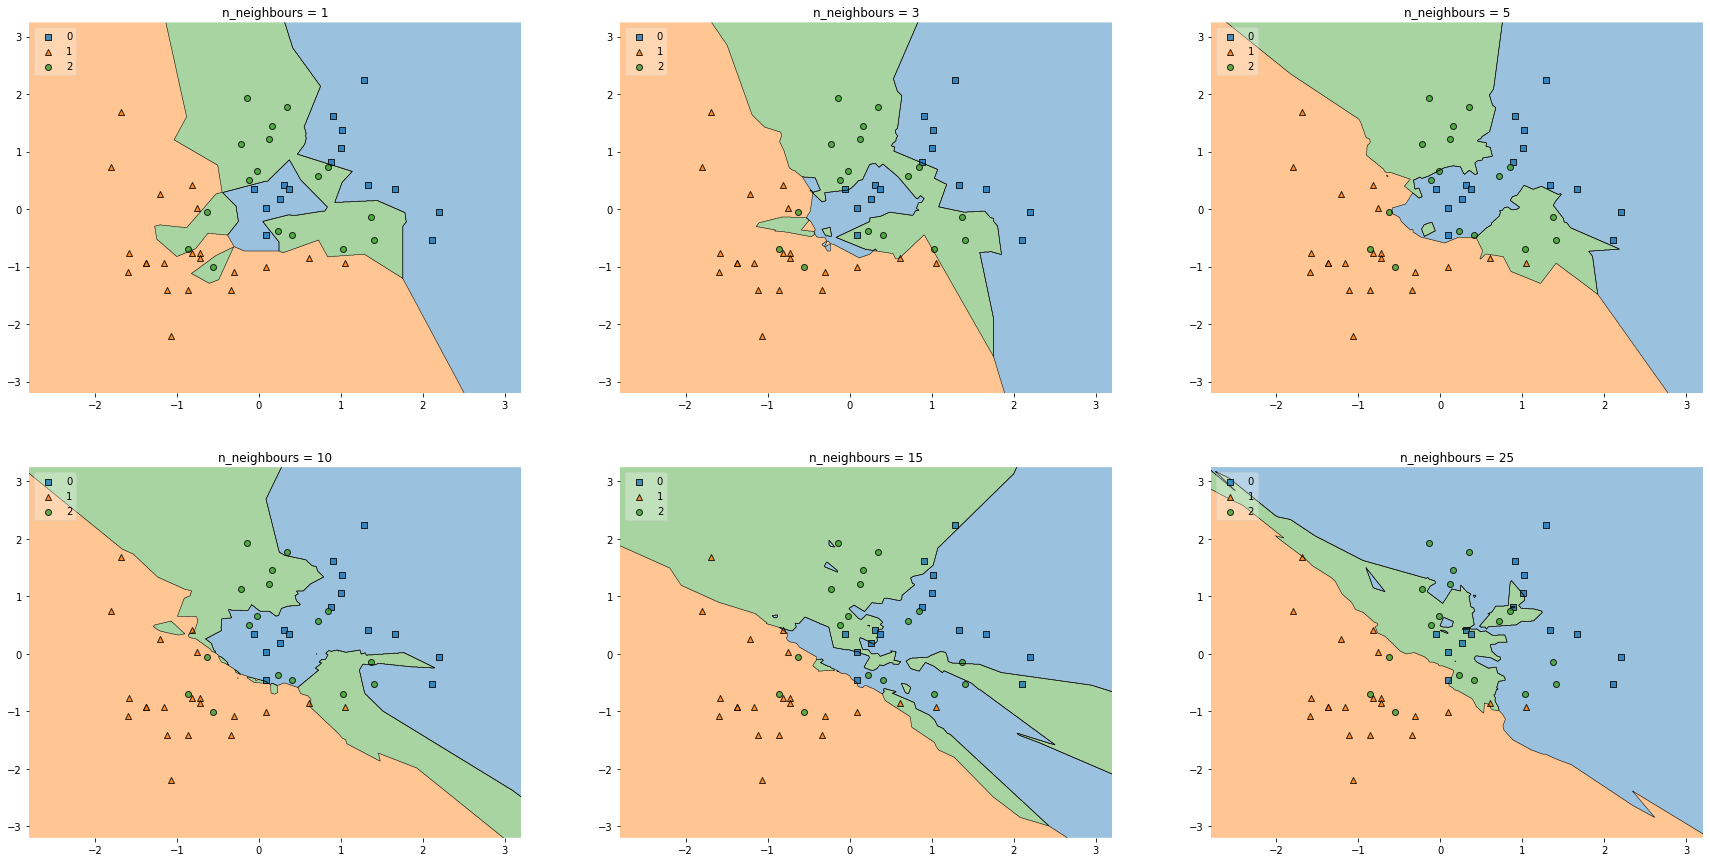

In [323]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(30,15))
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn5 = KNeighborsClassifier(n_neighbors = 5)
knn10 = KNeighborsClassifier(n_neighbors = 10)
knn15 = KNeighborsClassifier(n_neighbors = 15)
knn25 = KNeighborsClassifier(n_neighbors = 25)
labels = ['n_neighbours = 1', 'n_neighbours = 3', 'n_neighbours = 5', 'n_neighbours = 10', 'n_neighbours = 15', 'n_neighbours = 25']
for clf, lab, grd in zip([knn1, knn3, knn5, knn10, knn15, knn25],
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):

    clf.fit(X_train[['alcohol', 'magnesium']], y_train)
    print(gs[grd[0], grd[1]])
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train[['alcohol', 'magnesium']].to_numpy(), y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

В задаче 1.3 видно, что при  n_neighbours =1 мы всегда получим accuracy =1.0 на тренировочной выборке, что очевидно, однако на тестовой выборке мы получим плохой результат, что тоже очевидно. При увеличении количества соседей accuracy на тестовой выборке тоже увеличивалась, что хорошо. Самые оптимальные значения  n_neighbours в итоге для этого задания: 25 или 10. 
В 1.5 можно определить оптимальные значения по тому, насколько "гладкий" график мы получили. Опять же, для случая  n_neighbours =1 каждая точка из тренировочной выборки попадает идеально в область своего цвета, но применив это к новой тестовой выборке мы получим плохие результаты. В случае  n_neighbours =25, наоборот, график начал упускать слишком много точек: заметно, что зеленые точки очень часто оказываются не в своей области, что тоже не очень хорошо. Мне кажется, что оптимально выглядят графики для n_neighbours = 5 и n_neighbours = 10. В этих случаях хотя у нас и есть ошибки, но графики довольно гладкие и без множества разрывов и выбросов как при 3 и 15. 

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

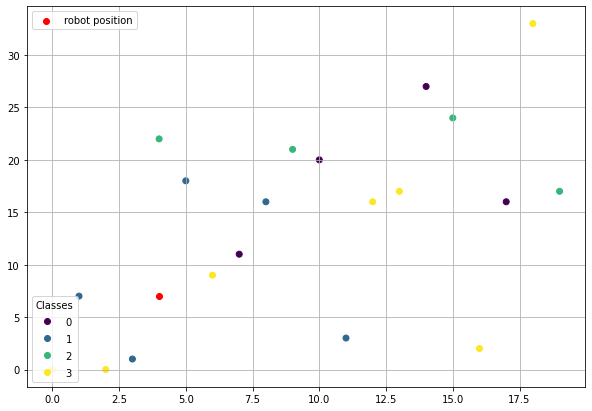

In [324]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [325]:
from sklearn.neighbors import KNeighborsClassifier

In [326]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        
        '''
        # Store the history of movements
        
        self.trajectory = [initial_position]
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k)
        self.knn.fit(landmarks, classes)
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        coin = np.random.binomial(n = 1, p = 0.2, size = 1)
        if coin[0] == 1: 
            new_position = self.mapping[0] + self.trajectory[-1]
            self.trajectory.append(new_position)
        else: 
            class_predict = int(self.knn.predict(self.trajectory[-1].reshape(1,-1)))
            new_position = self.mapping[class_predict] + self.trajectory[-1]
            self.trajectory.append(new_position)

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [327]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = np.array(robot.trajectory)
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

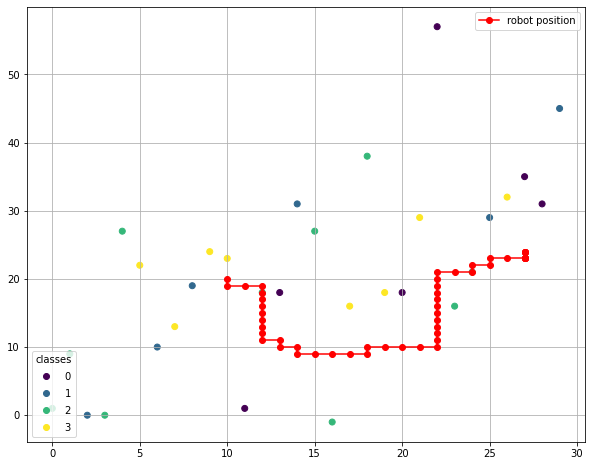

In [328]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? 
## Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

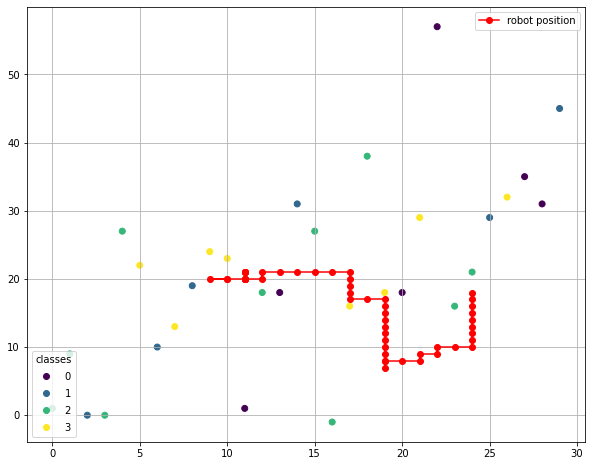

In [329]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 1, n_movements = 50)

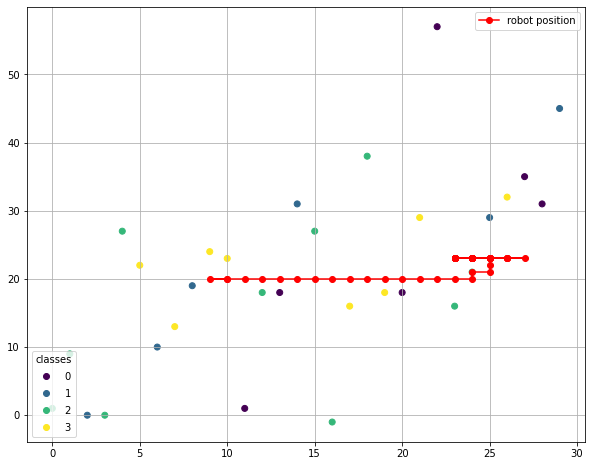

In [365]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 2, n_movements = 50)

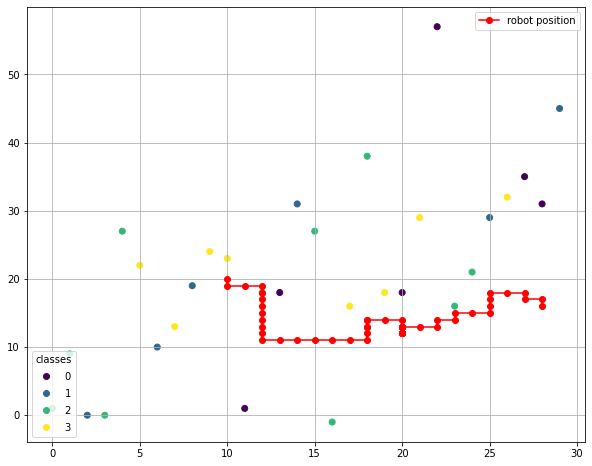

In [331]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 10, n_movements = 50)

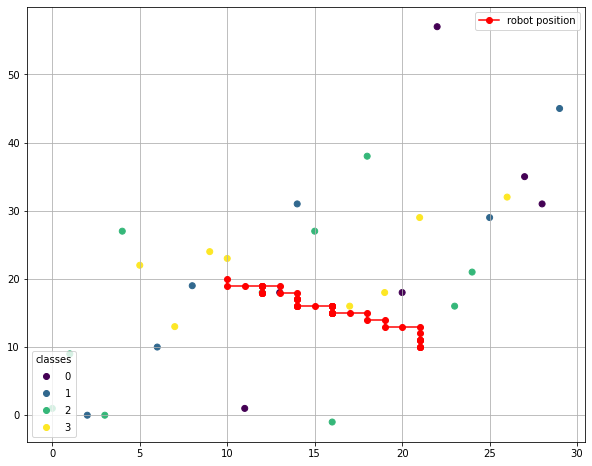

In [364]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 23, n_movements = 50)

Мне кажется, что нет какой-либо прямой зависимости между числом соседей и движением робота, потому что все зависит от того, как точки разбросаны по полю. Однако, когда мы берем очень маленькое число соседей - робот резко и часто меняет свое направление, когда мы берем большое число соседей - робот двигается в направлении, которое указывает большее количество точек одного и того же класса. Если бы у меток было осмысленное значение, мы бы получили при достаточно большом k то направление, в котором у нас более плотно раставлены точки. 

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [333]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [334]:
X.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [335]:
data.drop(columns = ['Unnamed: 0'],axis = 1, inplace=True)

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [336]:
data.corr()['price']

carat    0.921591
depth   -0.010647
table    0.127134
price    1.000000
x        0.884435
y        0.865421
z        0.861249
Name: price, dtype: float64

Целевая переменная коррелирует с carat больше всего, но также существенная корреляция наблюдается с признаками x, y, z.

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [337]:
for i in ['cut', 'color', 'clarity']: 
    one_hot = pd.get_dummies(data[i])
    data = data.drop(i,axis = 1)
    data = data.join(one_hot)
data

,carat,depth,table,price,x,y,z,Fair,Good,Ideal,...,I,J,I1,IF,SI1,SI2,VS1,VS2,VVS1,VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,0,1,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [338]:
X = data.drop('price', axis = 1)
y = data['price']

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.3, 
                                                    random_state=42)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [340]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [341]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [342]:
model = LinearRegression().fit(X_train, y_train)
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.9222043204176276


In [343]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Train: {}".format(mean_squared_error(y_train, y_train_pred)))
print("Test: {}".format(mean_squared_error(y_test, y_test_pred)))

Train: 1251945.0510541848
Test: 1293290.655574907


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [344]:
sorted(list(zip(X.columns, model.coef_)), 
       key=lambda x: abs(x[1]))

[('Very Good', -5.781225544525564),
 ('Premium', 15.273233857712114),
 ('y', -34.15687687631506),
 ('Good', -40.61313231448065),
 ('z', -49.76041175844536),
 ('table', -56.43188252126976),
 ('Ideal', 57.17640856187355),
 ('G', 61.458518089064725),
 ('depth', -79.3473298347586),
 ('VS2', 101.51228050674297),
 ('Fair', -122.82170897612927),
 ('H', -134.12562914925104),
 ('F', 141.29014706964634),
 ('SI1', -153.63249691508992),
 ('E', 155.00206088883562),
 ('VS1', 200.38133170731788),
 ('D', 210.92088090873395),
 ('IF', 230.7900553111946),
 ('VVS1', 245.97077205022276),
 ('I', -259.6231307566431),
 ('VVS2', 288.6444791928881),
 ('J', -367.853546612987),
 ('I1', -447.0639986181593),
 ('SI2', -494.0922619106988),
 ('x', -1189.1309555183357),
 ('carat', 5461.726837015176)]

Коэффициенты carat и х оказались на порядок выше всех остальных коэффициентов вещественных переменных

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [345]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [346]:
ridge = Ridge(10).fit(X_train,y_train)
print ("Train: {}".format(mean_squared_error(y_train, ridge.predict(X_train))))
print ("Test: {}".format(mean_squared_error(y_test, ridge.predict(X_test))))


Train: 1252356.0842074119
Test: 1293057.034229563


In [347]:
sorted(list(zip(X.columns, ridge.coef_)), 
       key=lambda x: abs(x[1]))

[('Very Good', -4.728287531357378),
 ('Premium', 14.454346787029737),
 ('Good', -40.46331564805496),
 ('table', -56.09458219146309),
 ('Ideal', 57.239977359051835),
 ('G', 60.791467481574074),
 ('depth', -71.80596832797261),
 ('z', -73.32067803063569),
 ('y', -95.8133035888919),
 ('VS2', 101.21352244243552),
 ('Fair', -123.76875344018266),
 ('H', -133.49550145384674),
 ('F', 140.24078776807167),
 ('E', 154.328129058657),
 ('SI1', -154.98920034557722),
 ('VS1', 199.90830685596634),
 ('D', 210.32563231949524),
 ('IF', 231.69619737852045),
 ('VVS1', 247.06920989263176),
 ('I', -257.864111866532),
 ('VVS2', 289.401636262602),
 ('J', -366.2008339162499),
 ('I1', -446.2568618978673),
 ('SI2', -493.7329441952157),
 ('x', -1014.2203847316426),
 ('carat', 5369.806016632224)]

 Вес carat уменьшился не сильно: с 5461.7 до 5369.8

In [348]:
lasso = Lasso(10).fit(X_train, y_train)
print ("Train: {}".format(mean_squared_error(y_train, lasso.predict(X_train))))
print ("Test: {}".format(mean_squared_error(y_test, lasso.predict(X_test))))

Train: 1263941.8009406812
Test: 1299806.5579591582


In [349]:
sorted(list(zip(X.columns, lasso.coef_)), 
       key=lambda x: abs(x[1]))

[('y', -0.0),
 ('Premium', 0.0),
 ('G', -0.0),
 ('VS2', -0.0),
 ('Very Good', -3.8827722458966103),
 ('Good', -40.42663466151337),
 ('depth', -41.830028057307814),
 ('table', -43.13102147910829),
 ('Ideal', 48.95521973968938),
 ('F', 65.74663604950068),
 ('E', 79.89496704265106),
 ('z', -82.45671392209857),
 ('VS1', 99.37325517136331),
 ('Fair', -123.23589483953666),
 ('D', 143.3392944113106),
 ('VVS1', 180.31124224443778),
 ('IF', 180.34751462558106),
 ('H', -180.41464643959452),
 ('VVS2', 211.88723614618203),
 ('SI1', -260.3157087832212),
 ('I', -290.5993512895348),
 ('J', -385.71746030216275),
 ('I1', -461.3428582932831),
 ('SI2', -575.2507057896548),
 ('x', -707.8361920056882),
 ('carat', 4958.112359026492)]

Тут коэффициент уменьшился чуть сильнее: с 5461.7 до 4958.1. Однако все равно регуляризация почти не изменила величину коэффициентов, а значит, что проблема мультиколлинеарности проявлялась на изначальной выборке не сильно.

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? 

In [350]:
lasso_params = []
ridge_params = []
alpha = [0.1, 1, 10, 100, 200]
for i in alpha: 
    lasso = Lasso(i).fit(X_train, y_train)
    lasso_params.append(np.linalg.norm(lasso.coef_))
    ridge = Ridge(i).fit(X_train,y_train)
    ridge_params.append(np.linalg.norm(ridge.coef_))
    
    
    

/Users/polinakrupica/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105591472.69884491, tolerance: 26041259.520984087
  model = cd_fast.enet_coordinate_descent(


In [351]:
print(pd.DataFrame({'alpha': alpha, 'lasso': lasso_params, 'ridge': ridge_params}))


   alpha        lasso        ridge
0    0.1  5687.565384  5682.499657
1    1.0  5633.906521  5670.605740
2   10.0  5112.915345  5561.676317
3  100.0  3969.559779  4822.745793
4  200.0  3656.788256  4289.948635


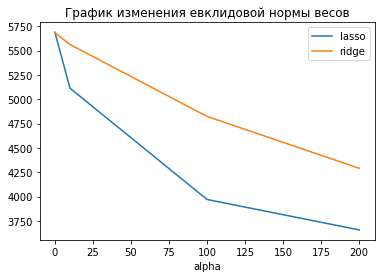

In [352]:
plt.plot(alpha, lasso_params, label = "lasso")
plt.plot(alpha, ridge_params, label = "ridge")
plt.xlabel('alpha')
plt.title('График изменения евклидовой нормы весов')
plt.legend()
plt.show()

Очевидно, что метод Lasso агрессивней уменьшает веса. Lasso-регрессия помогает понять, какие признаки наиболее информативные, поэтому ее используют для отбора признаков.

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [353]:
from sklearn.linear_model import LassoCV
lasso = Lasso()
lasso_cv = LassoCV( alphas =[0.1, 1, 10, 100, 200], cv =5)
lasso_cv.fit(X_train, y_train)

/Users/polinakrupica/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44828453.212947845, tolerance: 21173460.764760643
  model = cd_fast.enet_coordinate_descent_gram(
/Users/polinakrupica/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2676708021.7011642, tolerance: 21173460.764760643
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5)

In [354]:
print(lasso_cv.mse_path_)

[[2008415.6244359  1900272.96776424 1808052.82428452 1882531.79558815
  2022040.07439098]
 [1586687.06495728 1500461.97322674 1413455.54694349 1480955.23745065
  1585782.7743908 ]
 [1312028.77529565 1276304.43631558 1210757.51384847 1247193.24668407
  1311021.6167575 ]
 [1288200.53213142 1269845.06647428 1224314.32506455 1238151.97565681
  1289617.0293454 ]
 [1287507.02468956 1270874.10375873 1256692.26335085 1238639.95075792
  1289236.64384305]]


In [355]:
np.mean(lasso_cv.mse_path_, axis = 1)

array([1924262.65729276, 1513468.51939379, 1271461.11778026,
       1262025.78573449, 1268589.99728002])

In [356]:
print(pd.DataFrame({'alpha': lasso_cv.alphas_, 'mean_mse_cv': np.mean(lasso_cv.mse_path_, axis = 1)}))

   alpha   mean_mse_cv
0  200.0  1.924263e+06
1  100.0  1.513469e+06
2   10.0  1.271461e+06
3    1.0  1.262026e+06
4    0.1  1.268590e+06


In [357]:
print('Наименьшее значение mse:', min(np.mean(lasso_cv.mse_path_, axis = 1)))

Наименьшее значение mse: 1262025.785734489


Таким образом, лучшее значение альфа: 1

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [358]:
lasso = Lasso(1).fit(X_train, y_train)
sorted(list(zip(X.columns, lasso.coef_)), 
       key=lambda x: abs(x[1]))

[('Premium', 0.0),
 ('G', -0.0),
 ('VS2', -0.0),
 ('y', -4.940653571894448),
 ('Very Good', -19.41480796467607),
 ('Ideal', 40.507382915672224),
 ('Good', -49.94243936518455),
 ('table', -55.01467139777111),
 ('z', -55.60451576976349),
 ('depth', -75.03461894550937),
 ('F', 82.19936538725068),
 ('E', 95.47148437314257),
 ('VS1', 112.41379664685788),
 ('Fair', -128.09453730348986),
 ('D', 159.31043323129703),
 ('VVS1', 185.48497931940554),
 ('IF', 186.74643922171364),
 ('H', -188.08417783149648),
 ('VVS2', 217.70930926033648),
 ('SI1', -258.1651469315847),
 ('I', -304.12588945592955),
 ('J', -399.14409161721903),
 ('I1', -472.8678981428053),
 ('SI2', -583.3600017625615),
 ('x', -1162.8202565498566),
 ('carat', 5409.9674255192685)]

Таким образом, самыми информативными получились признаки carat и x (length mm). Это было предсказуемо, потому что в первую очередь определяется каратом (массой бриллианта) и его длиной. Также относительно важными признаками оказались те, которые связаны с clarity и color. 

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7.Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [359]:
y_test_pred = lasso.predict(X_test)
y_train_pred = lasso.predict(X_train)

In [360]:
print ("Train: {}".format(mean_squared_error(y_train, y_train_pred)))
print ("Test: {}".format(mean_squared_error(y_test, y_test_pred)))

Train: 1252067.6014955794
Test: 1292801.822544869


В 3.7 среднеквадрпатичная ошибка на тестовой выборка оказалась 1293290.655574907, то есть больше, чем 1292801.822544869. Следовательно, лучше использовать модель с Лассо-регрессией. Это произошло благодаря тому, что регуляризация уменьшает ненужные отклонения в модели и позволяет уменьшить веса коэффициентов. 